In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
from src import utils,physics
from src.density import NFW
from src.spatial_approximation import Lattice
from src.halo import Halo
from src.constants import G,Msun,kpc,Myr,cross_section,km,second

## Constants and general functions

In [3]:
# Mtot = 1.0e10 * Msun #Default halo mass in solar masses (Msun).
Mtot = 1.15e9 * Msun #Default halo mass in solar masses (Msun).
# Rs = 2.68441 * kpc #kpc
Rs = 1.18 * kpc #kpc
# c = 17
c = 19

sigma = 50 * cross_section

## Setup

In [4]:
n_particles = int(1e5)
nfw = NFW(Rs=Rs,c=c,Mtot=Mtot,Rmin=1e-4*kpc,Rmax=85*Rs,unit_mass=Mtot/n_particles)
steps_per_Tdyn = 1000
total_run_time = 1100 * nfw.Tdyn
save_every = 10*nfw.Tdyn

halo = Halo.setup(n_particles=n_particles,initial_density=nfw,sigma=sigma,steps_per_Tdyn=steps_per_Tdyn,save_every=save_every,
                  total_run_time=total_run_time)

In [5]:
halo.reset()
halo.evolve(n_Tdyn=1100)
# halo.evolve(n_Tdyn=81)
# halo.evolve(n_Tdyn=6)

100%|██████████████████████████████████████████████████████████| 1100000/1100000 [3:07:58<00:00, 97.53it/s]


In [11]:
halo.n_interactions

456671

In [ ]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

<Axes: xlabel='r', ylabel='Count'>

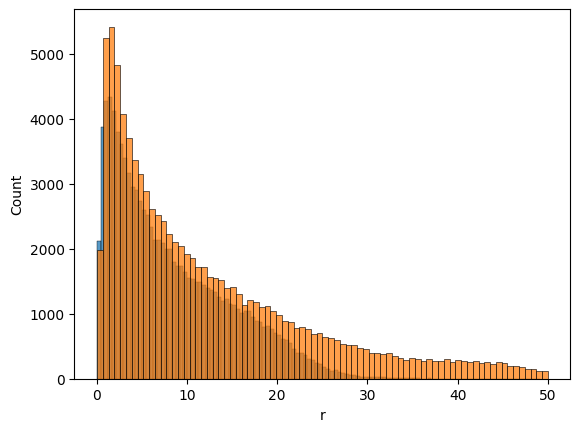

In [7]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)

<Axes: xlabel='time', ylabel='bin'>

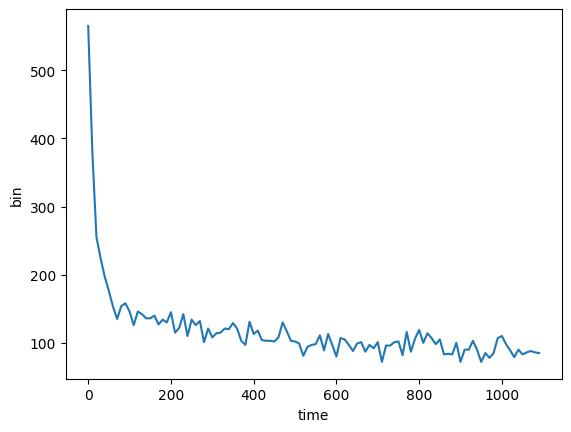

In [8]:
data = halo.saved_states.copy()
data['time'] /= halo.Tdyn
data['bin'] = data['r'] < 0.2*kpc
agg_data = data.groupby('time').bin.agg('sum')
sns.lineplot(agg_data)

Text(37.722222222222214, 0.5, 'Time [Tdyn]')

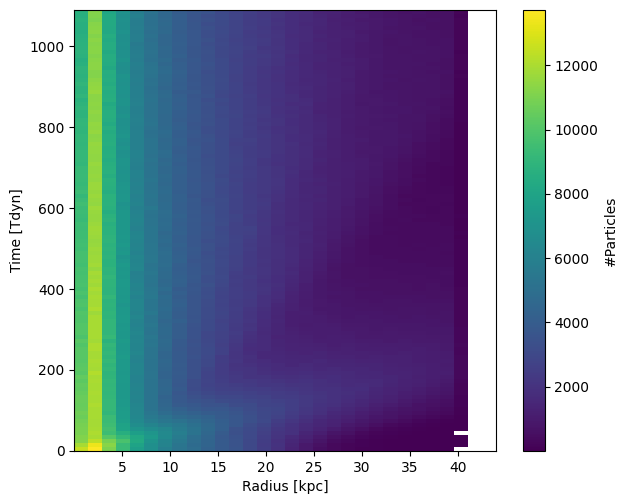

In [9]:
data = halo.saved_states.copy()
data['time'] /= halo.Tdyn
data = data[data['r'] < 40*kpc]
data['r_bin'] = data.r**2
l = Lattice(n_posts=30,start=data.r.min(),end=data.r.max()*1.1,log=False)
data['bin'] = l.posts[l(data.r)]
agg_data = data.groupby(['time','bin']).r_bin.agg('count').reset_index()
r,time = np.meshgrid(l.posts,data['time'].unique())
pad = pd.DataFrame({'time':time.ravel(),'bin':r.ravel()})
pad['r_bin'] = np.nan
agg_data = pd.concat([agg_data,pad]).drop_duplicates(['time','bin']).sort_values(['time','bin'])
agg_data['bin'] /= kpc

grid = agg_data.r_bin.to_numpy().reshape(r.shape)
fig,ax = plt.subplots(figsize=(6,5))
fig.tight_layout()
im = ax.imshow(grid,origin='lower',aspect='auto',extent=[r.min()/kpc,r.max()/kpc,time.min(),time.max()])
cbar = fig.colorbar(im,ax=ax)
cbar.set_label('#Particles')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Time [Tdyn]')

Text(37.722222222222214, 0.5, 'Time [Tdyn]')

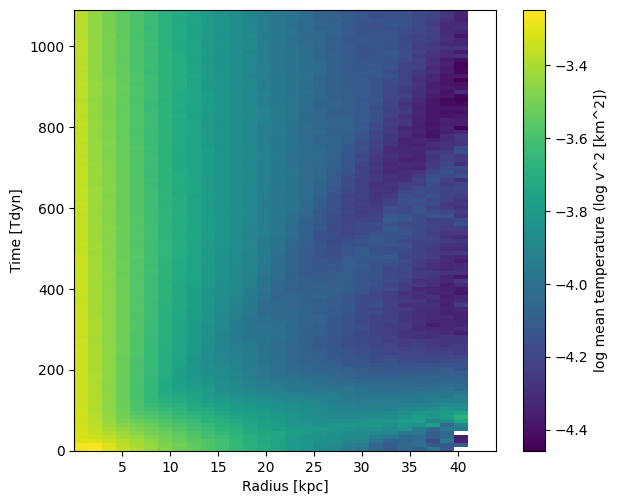

In [10]:
data = halo.saved_states.copy()
data['time'] /= halo.Tdyn
data = data[data['r'] < 40*kpc]
data['temperature'] = data.v_norm**2
l = Lattice(n_posts=30,start=data.r.min(),end=data.r.max()*1.1,log=False)
data['bin'] = l.posts[l(data.r)]
agg_data = data.groupby(['time','bin']).temperature.agg('mean').reset_index()
r,time = np.meshgrid(l.posts,data['time'].unique())
pad = pd.DataFrame({'time':time.ravel(),'bin':r.ravel()})
pad['temperature'] = np.nan
agg_data = pd.concat([agg_data,pad]).drop_duplicates(['time','bin']).sort_values(['time','bin'])
# agg_data['bin'] /= kpc

grid = agg_data.temperature.to_numpy().reshape(r.shape).copy()
fig,ax = plt.subplots(figsize=(6,5))
fig.tight_layout()
im = ax.imshow(np.log10(grid),origin='lower',aspect='auto',extent=[r.min()/kpc,r.max()/kpc,time.min(),time.max()])
cbar = fig.colorbar(im,ax=ax)
cbar.set_label('log mean temperature (log v^2 [km^2])')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Time [Tdyn]')

# Results:

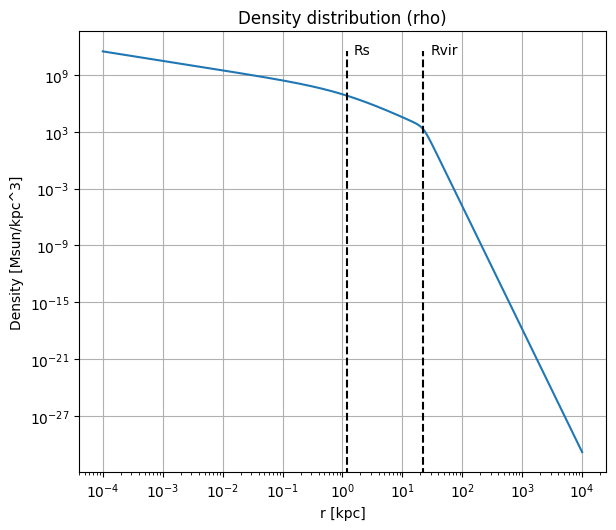

In [9]:
halo.initial_density.plot_rho();

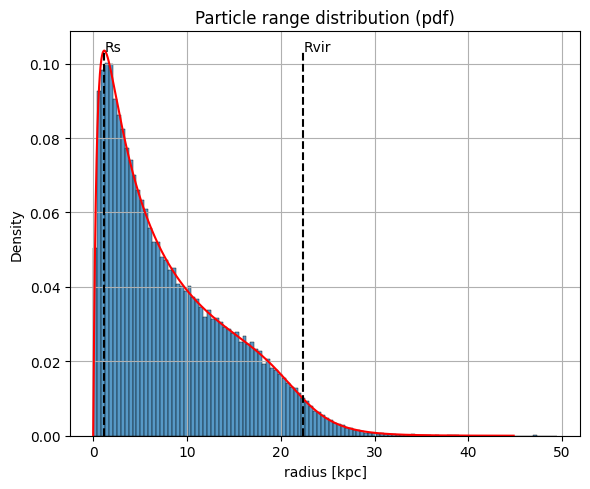

In [5]:
halo.plot_r_distribution(halo.initial_particles,cumulative=False);

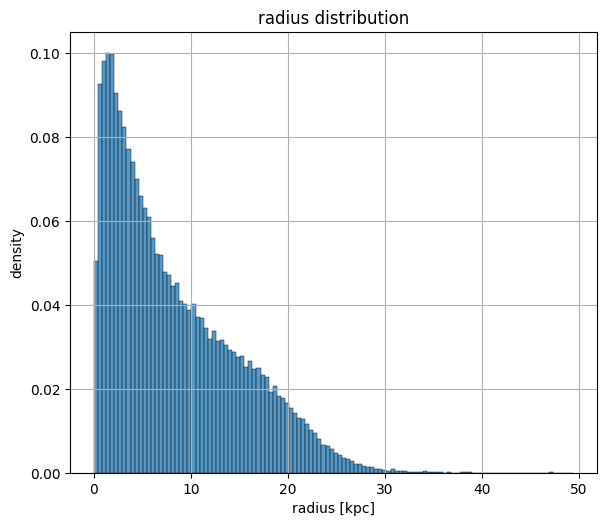

In [6]:
halo.plot_distribution('r',halo.initial_particles);

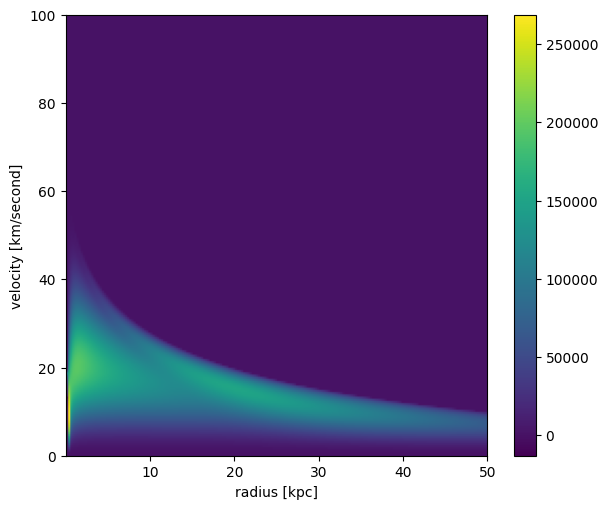

In [7]:
halo.initial_density.plot_phase_space();

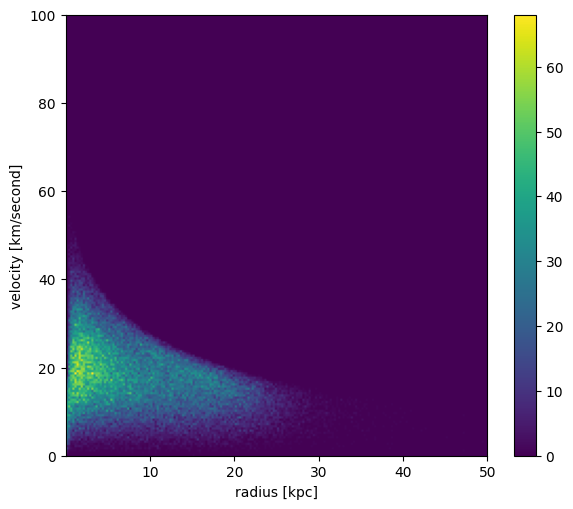

In [8]:
halo.plot_phase_space(halo.initial_particles);